In [66]:
import sys

import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy import stats

sys.path.append("/Users/eleni/Desktop/pymaxent/")
from pymaxent import *

In [2]:
with h5py.File("nz_qp_lens.h5", "r") as f:
    Z_MID = f['Z_MID'][::]
    nz_0 = f['nz_0'][::]

The goal is to test the pymaxent algorithm on a DESC n(z). We will do so as follows:
https://www.sciencedirect.com/science/article/pii/S2352711019302456

* Step 1: Generate a mock data set obeying the DESC n(z)
* Step 2: Test on a Gaussian
* Step 3: Run pymaxent on these moments
* Step 4: Compare the recovered distribution with the DESC n(z)

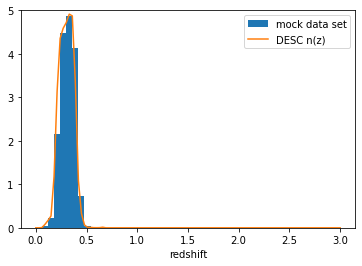

In [6]:
# Step 1

sample = np.random.choice(Z_MID, p = nz_0 / np.sum(nz_0), size = 100000)

plt.hist(sample, density = True, label = 'mock data set')
plt.plot(Z_MID, nz_0, label = 'DESC n(z)')
plt.xlabel("redshift")
plt.legend()
plt.ylim(0, 5)
plt.show()

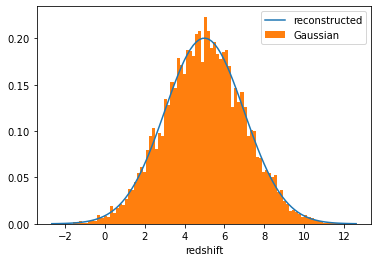

In [95]:
# Step 2

N = 3 # number of moments

sample = np.random.normal(5,2,10000)
binning = int(np.sqrt(len(sample)))

p,b = np.histogram(sample, bins=binning)
b = (b[1:] + b[:-1])/2

moments = np.zeros(N)

for i in range(N):
    moments[i] = np.sum(b**i*p)/len(sample)
    
bnd_low = min(sample)
bnd_high = max(sample)
x = np.linspace(bnd_low, bnd_high, binning)

sol, lambdas = reconstruct(moments, bnds=[bnd_low, bnd_high])

plt.plot(x, sol(x), label = 'reconstructed')
plt.hist(sample, label = 'Gaussian', density=True, bins=binning)
plt.legend()
plt.xlabel("redshift")
plt.show()

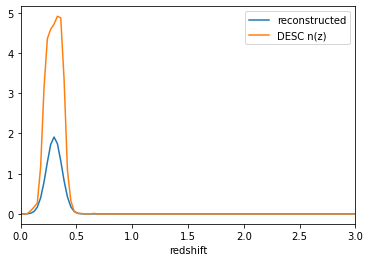

In [143]:
# Step 3: 

N = 3 # number of moments

x = Z_MID
p = nz_0

moments = np.zeros(N)

for i in range(N):
    moments[i] = np.sum(x**i*p)/len(Z_MID)
    
bnd_low = min(Z_MID)
bnd_high = max(Z_MID)

sol, lambdas = reconstruct(moments, bnds=[bnd_low, bnd_high])

# Step 4
plt.plot(x, sol(x), label = 'reconstructed')
plt.plot(Z_MID, nz_0, label = 'DESC n(z)')
plt.xlim(0, 3)
plt.legend()
plt.xlabel("redshift")
plt.show()